In [1]:
from numba import cuda
print(cuda.gpus)

<Managed Device 0>


In [2]:
import os
import gzip

import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from matplotlib import pyplot as plt

In [3]:
import esm
import torch
from tqdm import tqdm
from Bio import SeqIO

# Import Data

In [4]:
DATA_DIR = '/data/VariantAnalysis/'

PROTEOME_FASTA_FILE_PATH = os.path.join(DATA_DIR, 'uniprot/human_reviewed.fa.gz')
REPRESENTATIONS_DIR = os.path.join(DATA_DIR, 'esm1b_preprs')

In [30]:
GENES_OF_INTEREST = ['P53', 'RASK'] #['RASK','PTEN','TPMT','VKOR1','P53', 'ZAP70']  DNSL3 Protein

# Load the ESM1b model

In [7]:
torch.hub.get_dir()

'/home/ssm-user/.cache/torch/hub'

In [8]:
torch.hub.set_dir('/data/.cache/torch/hub/checkpoints/')

In [10]:
model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()

batch_converter = alphabet.get_batch_converter()
model.to(0)
print('Loaded ESM1b.')

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm1b_t33_650M_UR50S.pt" to /data/.cache/torch/hub/checkpoints/checkpoints/esm1b_t33_650M_UR50S.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm1b_t33_650M_UR50S-contact-regression.pt" to /data/.cache/torch/hub/checkpoints/checkpoints/esm1b_t33_650M_UR50S-contact-regression.pt


Loaded ESM1b.


# Protein sequence helper functions

In [31]:
ALL_AAS = list('ACDEFGHIKLMNPQRSTVWY')
ALL_AAS_SET = set(ALL_AAS)

def get_wt_mutation(seq, mutation_names_prefix = ''):
    return (mutation_names_prefix + 'WT', seq)

def get_all_mutations(seq, includeWT = True, mutation_names_prefix = ''):
    
    seq = str(seq)
    all_mutations = []
    
    if includeWT:
        all_mutations.append(get_wt_mutation(seq, mutation_names_prefix = mutation_names_prefix))

    for pos in range(len(seq)):
        
        ref_aa = seq[pos]
        alt_aa_options = ALL_AAS_SET - {ref_aa}
        
        for alt_aa in alt_aa_options:
            mutation_name = mutation_names_prefix + ref_aa + str(pos + 1) + alt_aa
            mutation_seq = seq[:pos] + alt_aa + seq[(pos + 1):]
            all_mutations.append((mutation_name, mutation_seq))

    return all_mutations

# Process the UniProt dataset

In [32]:
uniprot_records = []

with gzip.open(PROTEOME_FASTA_FILE_PATH, 'rt') as f:
    for record in SeqIO.parse(f, 'fasta'):
        gene_name = record.name.split('|')[-1].split('_')[0]
        uniprot_records.append((record.name, gene_name, str(record.seq)))

uniprot_records = pd.DataFrame(uniprot_records, columns = ['name', 'gene', 'seq'])
display(uniprot_records)

gene_name_to_uniprot_records = uniprot_records.groupby('gene')

,name,gene,seq
0,sp|P51451|BLK_HUMAN,BLK,MGLVSSKKPDKEKPIKEKDKGQWSPLKVSAQDKDAPPLPPLVVFNH...
1,sp|A6H8Y1|BDP1_HUMAN,BDP1,MFRRARLSVKPNVRPGVGARGSTASNPQRGRESPRPPDPATDSASK...
2,sp|O60885|BRD4_HUMAN,BRD4,MSAESGPGTRLRNLPVMGDGLETSQMSTTQAQAQPQPANAASTNPP...
3,sp|P22223|CADH3_HUMAN,CADH3,MGLPRGPLASLLLLQVCWLQCAASEPCRAVFREAEVTLEAGGAEQE...
4,sp|Q9BXJ4|C1QT3_HUMAN,C1QT3,MLWRQLIYWQLLALFFLPFCLCQDEYMESPQTGGLPPDCSKCCHGD...
...,...,...,...
20372,sp|O00471|EXOC5_HUMAN,EXOC5,MATTAELFEEPFVADEYIERLVWRTPGGGSRGGPEAFDPKRLLEEF...
20373,sp|Q5JX71|F209A_HUMAN,F209A,MWTLKSSLVLLLCLTCSYAFMFSSLRQKTSEPQGKVQYGEHFRIRQ...
20374,sp|P15036|ETS2_HUMAN,ETS2,MNDFGIKNMDQVAPVANSYRGTLKRQPAFDTFDGSLFAVFPSLNEE...
20375,sp|Q5XKK7|F219B_HUMAN,F219B,MATAEPSGRALRLSTPGPRPSGARDRAPGAAGPPSGQIGNRALRLG...


In [13]:
uniprot_records[uniprot_records.gene == 'P53']['seq'].tolist()

['MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLSPDDIEQWFTEDPGPDEAPRMPEAAPPVAPAPAAPTPAAPAPAPSWPLSSSVPSQKTYQGSYGFRLGFLHSGTAKSVTCTYSPALNKMFCQLAKTCPVQLWVDSTPPPGTRVRAMAIYKQSQHMTEVVRRCPHHERCSDSDGLAPPQHLIRVEGNLRVEYLDDRNTFRHSVVVPYEPPEVGSDCTTIHYNYMCNSSCMGGMNRRPILTIITLEDSSGNLLGRNSFEVRVCACPGRDRRTEEENLRKKGEPHHELPPGSTKRALPNNTSSSPQPKKKPLDGEYFTLQIRGRERFEMFRELNEALELKDAQAGKEPGGSRAHSSHLKSKKGQSTSRHKKLMFKTEGPDSD']

Text(0, 0.5, '#records')

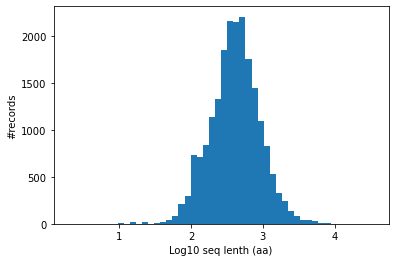

In [33]:
fig, ax = plt.subplots()
ax.hist(np.log10(uniprot_records['seq'].str.len()), bins = 50)
ax.set_xlabel('Log10 seq lenth (aa)')
ax.set_ylabel('#records')

In [34]:
genes = []
for gene_name in GENES_OF_INTEREST:
    (_, gene_uniprot_record), = gene_name_to_uniprot_records.get_group(gene_name).iterrows()
    seq = gene_uniprot_record['seq']
    genes.append((gene_name, seq))

In [19]:
# genes = []
# seq = "MPQTVILPGPAPWGFRLSGGIDFNQPLVITRITPGSKAAAANLCPGDVILAIDGFGTESMTHADAQDRIKAAAHQLCLKIDRGETHLWSPQVSEDGKAHPFKINLESEPQDGNYFEHKHNIRPKPFVIPGRSSGCSTPSGIDCGSGRSTPSSVSTVSTICPGDLKVAAKLAPNIPLEMELPGVKIVHAQFNTPMQLYSDDNIMETLQGQVSTALGETPLMSEPTASVPPESDVYRMLHDNRNEPTQPRQSGSFRVLQGMVDDGSDDRPAGTRSVRAPVTKVHGGSGGAQRMPLCDKCGSGIVGAVVKARDKYRHPECFVCADCNLNLKQKGYFFIEGELYCETHARARTKPPEGYDTVTLYPKA"
# genes.append(('PDLIM3', seq))

# Get WT logits

In [35]:
genes_and_wt_logits = []

for gene_name, seq in genes:
    
    mutations = [get_wt_mutation(seq, gene_name)]
    _, _, batch_tokens = batch_converter(mutations)
    
    with torch.no_grad():
        wt_logits = torch.log_softmax(model(batch_tokens.to(0), repr_layers = [33], return_contacts = False)['logits'], \
                dim = -1).cpu().numpy()
        wt_logits, = wt_logits # There should be only one sequence per batch
        
    genes_and_wt_logits.append((gene_name, seq, wt_logits))

print('Done.')

Done.


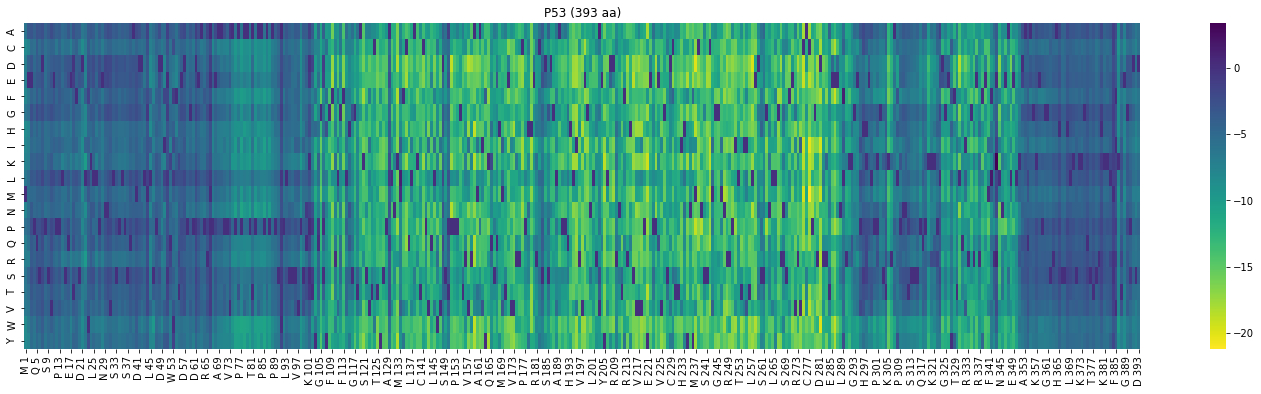

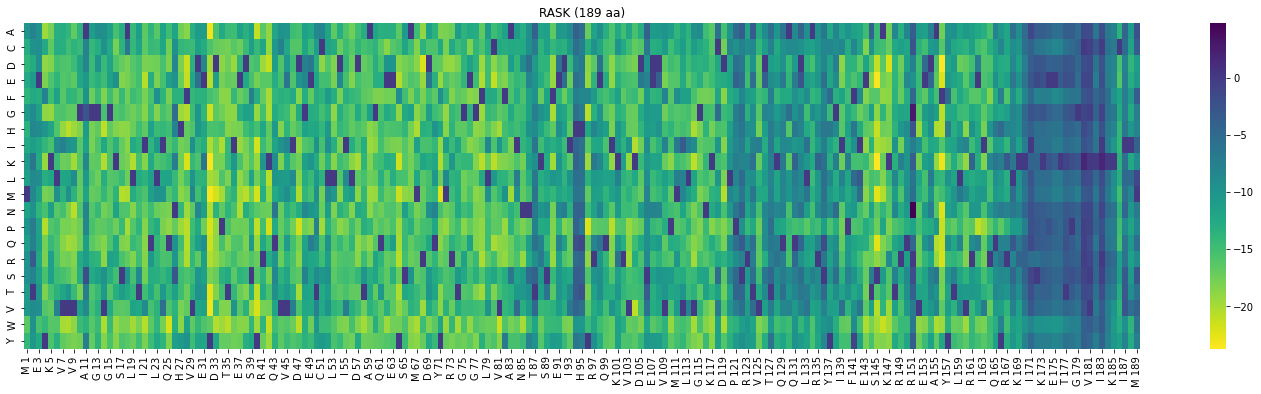

In [36]:
llr_dict = {}
for gene_name, seq, wt_logits in genes_and_wt_logits:
    
    wt_logits = pd.DataFrame(wt_logits[1:-1, :].transpose(), index = alphabet.all_toks, columns = list(seq))
    wt_logits.to_csv(os.path.join(REPRESENTATIONS_DIR, '%s_logits.csv' % gene_name))
    
    wt_ref_logits = np.array([pos_wt_logits[pos_ref_aa] for pos_ref_aa, pos_wt_logits in wt_logits.iteritems()])
    LLR = (wt_logits - wt_ref_logits.reshape(1, -1)).loc[ALL_AAS]
    llr_dict[gene_name] = LLR
    aa_columns = list(LLR)
    aa_indices = [index for index in range(1,len(aa_columns)+1)]
    LLR.columns = [aa+' '+str(index) for aa,index in zip(aa_columns,aa_indices)]
    LLR.to_csv('/data/VariantAnalysis/esm1b_preprs/'+gene_name+'_heatmap_logits.csv')
    
    fig, ax = plt.subplots(figsize = (25, 6))
    sns.heatmap(LLR, ax = ax, cmap = 'viridis_r')
    ax.set_title('%s (%d aa)' % (gene_name, len(seq)))

# Get representations for all point mutations

In [37]:
all_mutations = []

for gene_name, seq in genes:
    all_mutations.extend(get_all_mutations(seq, mutation_names_prefix = gene_name + ':'))
    
print('Overall %d mutations.' % len(all_mutations))

Overall 11060 mutations.


In [38]:
def chunk_list(values, chunk_size):
    for i in range(0, len(values), chunk_size):
        yield values[i:(i + chunk_size)]

batch_size = 64
mutation_names = []
mutation_reprs = []
    
for batch in tqdm(chunk_list(all_mutations, batch_size), total = int(np.ceil(len(all_mutations) / batch_size))): 

    _, _, batch_tokens = batch_converter(batch)
    
    with torch.no_grad():
        
        batch_reprs = model(batch_tokens.to(0), repr_layers = [33], return_contacts = False)['representations']

        for i, (mutation_name, seq) in enumerate(batch):
            mutation_names.append(mutation_name)
            mutation_reprs.append(batch_reprs[33][i, 1:(len(seq) + 1)].mean(axis = 0).cpu().numpy())
            
    del batch_tokens, batch_reprs
        
mutation_names = np.array(mutation_names)
mutation_reprs = np.stack(mutation_reprs)
print(mutation_reprs.shape)

100%|██████████████████████████████████████████████████████████████████████████████| 173/173 [27:15<00:00,  9.46s/it]

(11060, 1280)


In [39]:
for gene_symbol in GENES_OF_INTEREST:
    # print(gene_symbol)
# gene_symbol, = GENES_OF_INTEREST
    save_dir = os.path.join(REPRESENTATIONS_DIR, gene_symbol)
    os.mkdir(save_dir)
    np.save(os.path.join(save_dir, 'mutation_names.npy'), mutation_names)
    np.save(os.path.join(save_dir, 'mutation_reprs.npy'), mutation_reprs)